In [1]:
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader
from tqdm import tqdm  # For nice progress bar!
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [2]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.fc1 = nn.Linear(1024, num_classes)

    def forward(self, x):
        print("Input:",x.shape)
        x = F.relu(self.conv1(x))
        print("After 1st Conv:",x.shape)
        x = self.pool(x)
        print("After 1st Pooling:",x.shape)
        x = F.relu(self.conv2(x))
        print("After 2nd Conv:",x.shape)
        x = self.pool(x)
        print("After 2nd Pooling:",x.shape)
        x = x.reshape(x.shape[0], -1)
        print("After Flattening:",x.shape)
        x = self.fc1(x)
        print("Output:",x.shape)
        return x

Setting the device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Hyper-Parameters

In [4]:
in_channels = 1
num_classes = 10
learning_rate = 3e-4 # karpathy's constant
num_epochs = 3

Load the Data

In [5]:
train_dataset = datasets.CIFAR10(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.CIFAR10(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
type(train_dataset)

torchvision.datasets.cifar.CIFAR10

Randomly Printing some images

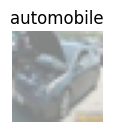

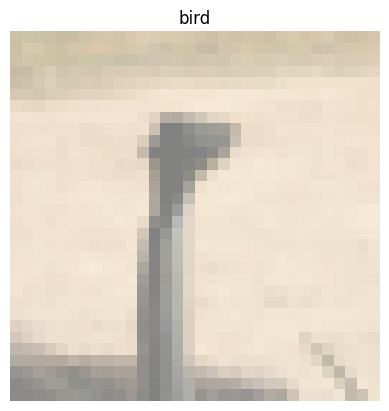

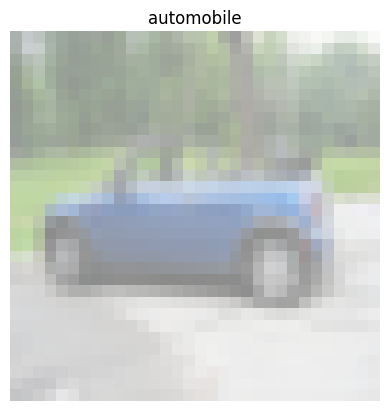

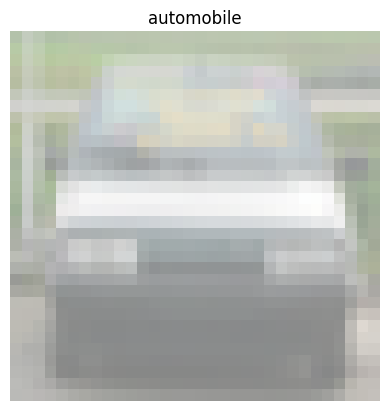

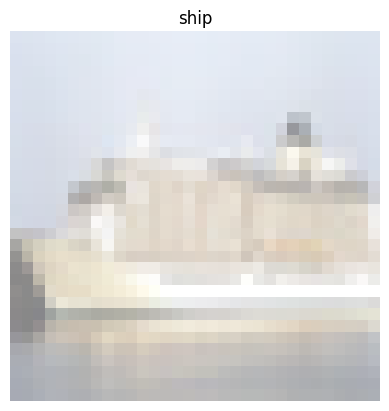

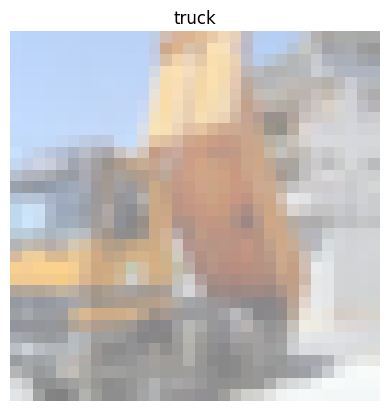

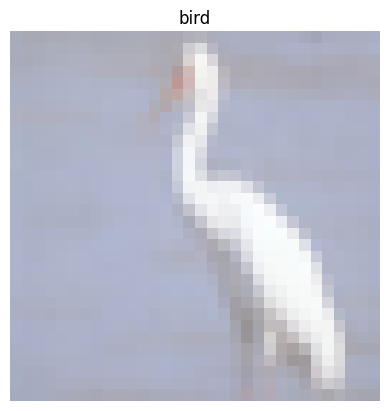

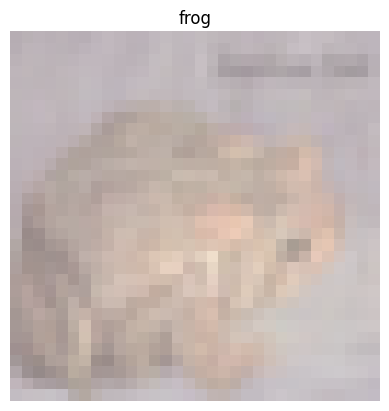

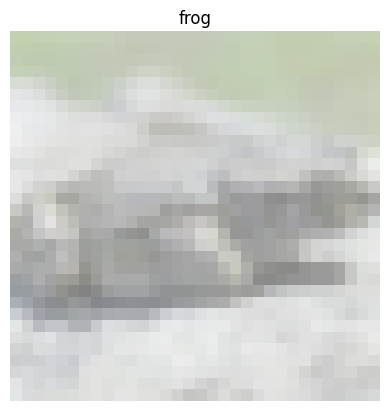

In [7]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
figure = plt.figure(figsize=(4, 4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    imshow(img)
plt.show()

Just one batch process

In [8]:
batch_size = 1
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
type(img)

torch.Tensor

Processing of a single batch

In [10]:
train_features, train_labels = next(iter(train_loader))

In [11]:
model = CNN(in_channels=3, num_classes=num_classes)
model(train_features)

Input: torch.Size([1, 3, 32, 32])
After 1st Conv: torch.Size([1, 8, 32, 32])
After 1st Pooling: torch.Size([1, 8, 16, 16])
After 2nd Conv: torch.Size([1, 16, 16, 16])
After 2nd Pooling: torch.Size([1, 16, 8, 8])
After Flattening: torch.Size([1, 1024])
Output: torch.Size([1, 10])


tensor([[ 0.0498,  0.0562,  0.1778, -0.1016,  0.0711,  0.1149,  0.2173, -0.1086,
         -0.1376,  0.1060]], grad_fn=<AddmmBackward0>)

All the batches

In [12]:
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.fc1 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

Initialize the network

In [14]:
model = CNN(in_channels=3, num_classes=num_classes).to(device)

Loss and optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Train Network

In [16]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples




100%|██████████| 3125/3125 [00:14<00:00, 221.26it/s]


In [17]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 52.99
Accuracy on test set: 52.76
